In [63]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import aggregate

def create_synthetic_data():
    """Generate long-format sales data with grouping columns."""
    dates = pd.date_range("2024-01-01", periods=100, freq="D")
    product_map = {
        "TV": "Electronics", "Laptop": "Electronics", 
        "TShirt": "Apparel", "Jeans": "Apparel"
    }
    rows = []
    for product, category in product_map.items():
        sales = np.random.randint(50, 150, size=100)
        for d, y in zip(dates, sales):
            rows.append({
                "item_id": product, # Name this 'item_id' to avoid 'unique_id' collision
                "ds": d,
                "y": float(y),
                "category": category
            })
    return pd.DataFrame(rows)


# Prepare data and define the hierarchy

In [67]:
# 1. Prepare Data
df_long = create_synthetic_data()

# 2. Build Hierarchy
# aggregate() will create the 'unique_id' column using these levels
hierarchy_spec = [['category'], ['category', 'item_id']]
hier_df, S_df, tags = aggregate(df=df_long, spec=hierarchy_spec)

# Generate Base Forecasts

In [68]:
# n_jobs=1 is required to prevent a BrokenProcessPool error
sf = StatsForecast(
    models=[AutoETS(season_length=7)],
    freq="D",
    n_jobs=1 
)
base_forecasts = sf.forecast(df=hier_df, h=12)

# 4. Reconciliation
reconcilers = [BottomUp(), MinTrace(method="ols")]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

final_forecasts = hrec.reconcile(
    Y_hat_df=base_forecasts,
    Y_df=hier_df,
    S_df=S_df,
    tags=tags
)

  unique_id         ds     AutoETS  AutoETS/BottomUp  \
0   Apparel 2024-04-10  197.651847        197.717471   
1   Apparel 2024-04-11  197.651847        197.717471   
2   Apparel 2024-04-12  197.651847        197.717471   
3   Apparel 2024-04-13  197.651847        197.717471   
4   Apparel 2024-04-14  197.651847        197.717471   
5   Apparel 2024-04-15  197.651847        197.717471   
6   Apparel 2024-04-16  197.651847        197.717471   
7   Apparel 2024-04-17  197.651847        197.717471   
8   Apparel 2024-04-18  197.651847        197.717471   
9   Apparel 2024-04-19  197.651847        197.717471   

   AutoETS/MinTrace_method-ols  
0                   197.673721  
1                   197.673721  
2                   197.673721  
3                   197.673721  
4                   197.673721  
5                   197.673721  
6                   197.673721  
7                   197.673721  
8                   197.673721  
9                   197.673721  
                    

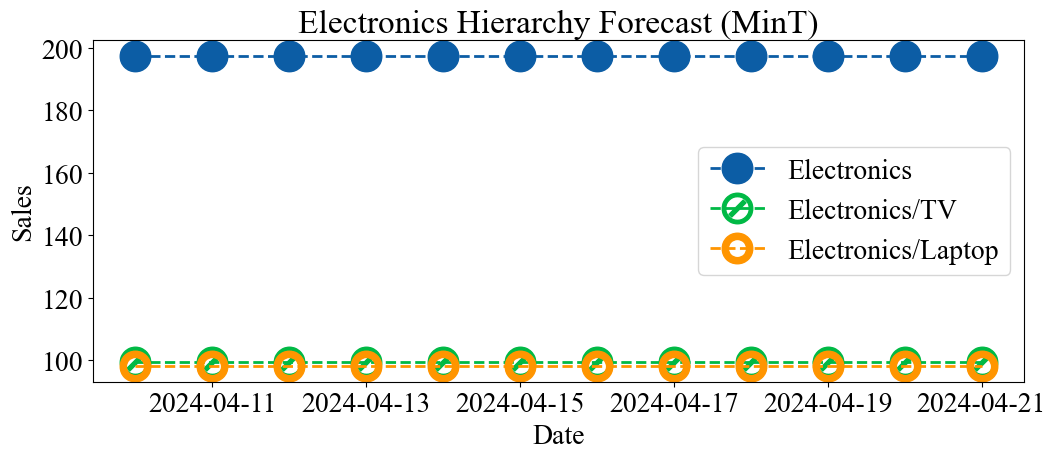

In [69]:
print(final_forecasts.head(10))
print(final_forecasts.groupby("unique_id")["AutoETS"].describe())
series_list = [
    "Electronics",
    "Electronics/TV",
    "Electronics/Laptop"
]

plt.figure(figsize=(11, 5))

for sid in series_list:
    fcst = final_forecasts[final_forecasts["unique_id"] == sid]
    plt.plot(fcst["ds"], fcst[method_col], label=sid)

plt.title("Electronics Hierarchy Forecast (MinT)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()
